## DSPy Demo
This notebook demonstrates the of DSPy framework for automatic prompt optimization.

In [1]:
%cd ../

/Users/jakubzovak/Desktop/dspy-intro


In [2]:
%load_ext autoreload
%autoreload 2

## Setup

In [29]:
import json
import os
from pathlib import Path
from typing import Literal, Any, cast

import dspy
from dotenv import load_dotenv
from dspy.adapters.baml_adapter import BAMLAdapter
from sklearn.model_selection import train_test_split
import mlflow

from notebooks.utils.dtos import Merger, Acquisition, Other
from notebooks.utils.evaluation import validate_answer
from notebooks.utils.helpers import extract_first_n_sentences, read_data, get_gt_pydantic_model, visualize_model_scores


Load environment with MlFlow and OpenAI keys.

In [4]:
load_dotenv()

True

## MlFlow Setup

Run MlFlow server for logging traces and tracking optimization runs.

In [5]:
MLFLOW_PORT = os.getenv("MLFLOW_PORT")

In [6]:
!docker run -d -p {MLFLOW_PORT}:5000 -v $(pwd)/mlruns:/mlflow/mlruns -e MLFLOW_TRACKING_URI=http://0.0.0.0:5000 \
  --name mlflow-server ghcr.io/mlflow/mlflow:v3.7.0 mlflow server \
    --host 0.0.0.0 \
    --port 5000 \
    --backend-store-uri sqlite:///mlflow.db \
    --default-artifact-root /mlflow/mlruns

9c4b76b78ae1bdfc3bc6d52e693fb9ba5591f6f3abaa309bae5e99f8589eb0b8


In [7]:
mlflow.set_tracking_uri(f"http://localhost:{MLFLOW_PORT}")

## DSPy

### Adapters
Adapters are basically middleware for communication with LLM. They support different way of interacting with LLM such as structured output.

In [8]:
predictor_lm = dspy.LM(
    model="openrouter/google/gemini-2.5-flash-lite",
    api_base="https://openrouter.ai/api/v1",
    api_key=os.getenv("OPENROUTER_API_KEY"),
)

dspy.configure(lm=predictor_lm, adapter=BAMLAdapter()) # type: ignore

Turn on MlFlow tracking with auto-logging for DSPy.

In [9]:
mlflow.set_experiment("DSPy Demo")
mlflow.dspy.autolog(log_compiles=True, log_evals=True, log_traces_from_compile=True)

2025/12/10 09:08:10 INFO mlflow.tracking.fluent: Experiment with name 'DSPy Demo' does not exist. Creating a new experiment.
2025/12/10 09:08:10 WARNING mlflow.utils.autologging_utils: MLflow dspy autologging is known to be compatible with 2.5.41 <= dspy, but the installed version is 3.0.4b1. If you encounter errors during autologging, try upgrading / downgrading dspy to a compatible version, or try upgrading MLflow.


### Signatures
Signatures are declarative specification of the desired behavior that we expect from the LLM.

In [10]:
class ClassifyArticle(dspy.Signature):
    """
    Analyze the news article and classify it as a merger or acquisition deal.
    - A merger is when two companies combine to form a new entity.
    - An acquisition is when one company takes over another.
    - If it mentions a potential, rumored or failed deal, classify it as "Other".
    """

    text: str = dspy.InputField()
    article_type: Literal["merger", "acquisition", "other"] = dspy.OutputField()


class ExtractMergerInfo(dspy.Signature):
    """
    Extract information about companies involved in a merger deal.
    - If the currency symbol is just "$", assume USD.
    """

    text: str = dspy.InputField()
    merger_info: Merger = dspy.OutputField()


class ExtractAcquisitionInfo(dspy.Signature):
    """
    Extract information about companies involved in an acquisition deal.
    - If the currency symbol is just "$", assume USD.
    """

    text: str = dspy.InputField()
    acquisition_info: Acquisition = dspy.OutputField()

### Modules
Modules are core building block in DSPy that combine signatures and logic. Modules are composable and therefore can be combined to form more complex systems.

In [11]:
class Extract(dspy.Module):
    num_sentences: int = 5

    def __init__(self):
        self.classifier = dspy.Predict(ClassifyArticle)
        self.merger_extractor = dspy.Predict(ExtractMergerInfo)
        self.acquisition_extractor = dspy.Predict(ExtractAcquisitionInfo)

    def classify(self, text: str) -> str:
        text = extract_first_n_sentences(text, num_sentences=self.num_sentences)

        result = self.classifier(text=text)
        article_type : str = result.article_type # type: ignore

        return article_type


    def forward(self, text: str, article_id: int) -> Merger | Acquisition | Other:
        article_type = self.classify(text)

        if article_type == "merger":
            extracted_result = self.merger_extractor(text=text)
            merger_info : Merger = extracted_result.merger_info
            merger_info.article_id = article_id
            return merger_info
        
        elif article_type == "acquisition":
            extracted_result = self.acquisition_extractor(text=text)
            acquisition_info : Acquisition = extracted_result.acquisition_info
            acquisition_info.article_id = article_id
            return acquisition_info
        else:
            return Other(article_id=article_id, article_type="other")

## Data Preparation
Load articles about gold mining mergers and acquisitions.

In [12]:
articles = read_data(Path("data/articles.json"))
print(f"Example of loaded article with id {articles[0]['id']}: \n{json.dumps(articles[0], indent=2)}")

Example of loaded article with id 1: 
{
  "id": 1,
  "url": "https://www.australianmining.com.au/elevra-lithium-a-defining-moment-in-north-american-lithium/",
  "title": "Elevra: \u2018A defining moment in North American lithium\u2019",
  "date": "2025-04-09",
  "content": "The company to be created through the merger of ASX-listed Sayona Mining and Piedmont Lithium will be named Elevra Lithium, subject to Sayona shareholder approval. Originally announced in November 2024, the merger is set to create the largest hard-rock lithium producer in the US. The transaction will result in an approximate 50:50 equity holding for Sayona and Piedmont shareholders on a fully diluted basis following the deal\u2019s closing, which is expected in the first half of 2025. Now the merged entity has been named, nominees for the board have been announced. The Elevra Lithium board will initially comprise eight members, including four directors to be appointed by Sayona and four directors to be appointed by 

Load ground truth about the articles which contains their classification and information extraction.

In [13]:
ground_truths: list[dict[str, Any]] = read_data(Path("data/ground_truth.json"))
print(f"Example of loaded ground truth with id {ground_truths[0]['article_id']}: \n{json.dumps(ground_truths[0], indent=2)}")


Example of loaded ground truth with id 1: 
{
  "article_id": 1,
  "company_1": "Sayona Mining",
  "company_1_ticker": null,
  "company_2": "Piedmont Lithium",
  "company_2_ticker": null,
  "merged_entity": "Elevra Lithium",
  "deal_amount": null,
  "deal_currency": "Unknown",
  "article_type": "merger"
}


Convert data to DSPy examples.

In [14]:
NUM_SENTENCES = 5
dspy_examples: list[dspy.Example] = []
for article  in articles:
    ground_truth: dict[str, Any] = ground_truths[article["id"] - 1] # type: ignore
    gt_pydantic_model = get_gt_pydantic_model(ground_truth)
    example = dspy.Example(
        text=(
            article["title"] + "\n" + extract_first_n_sentences(article["content"], NUM_SENTENCES)
        ), 
        article_id=article["id"], 
        expected_output=gt_pydantic_model
    ).with_inputs("text", "article_id") # type: ignore
    dspy_examples.append(example)

Perform train-test split. For DSPy we actually do not need lot of training data.  <br>
In fact, using something **around 20-80 train-test split is quite standard**.

In [15]:
train_set, test_set = cast(
    tuple[list[dspy.Example], list[dspy.Example]],
    train_test_split(dspy_examples, test_size=0.50, random_state=39)
)

print(f"Train set size: {len(train_set)} \nTest set size:  {len(test_set)}")

Train set size: 20 
Test set size:  20


## Run Baseline DSPy Program

Instantiate and test out baseline DSPy program without any optimization.

In [16]:
baseline_extract = Extract()

Execute the baseline module.

In [17]:
extracted_article_1 = baseline_extract(text=train_set[0].text, article_id=train_set[0].article_id)

Trace(trace_id=tr-28d55c4ace40166d3edfb84ce5393391)

In [18]:
print(f"Extracted article:\n{extracted_article_1.model_dump_json(indent=2)}")

Extracted article:
{
  "article_id": 27,
  "parent_company": "Blue Canyon Coal",
  "parent_company_ticker": null,
  "child_company": "Highland Basin Resources",
  "child_company_ticker": null,
  "deal_amount": "2.2 bn",
  "deal_currency": "USD",
  "article_type": "acquisition"
}


Explore the underlying prompt. With `n=1` you will see extraction prompt. While with `n=2` you will see classification prompt.

In [ ]:
# dspy.inspect_history(n=1)

Store the baseline extractor as DSPy program in JSON format.

In [19]:
BASELINE_PROGRAM_PATH = "programs/baseline_extractor.json"
baseline_extract.save(BASELINE_PROGRAM_PATH)

## Optimizations

### LabelFewShot Optimizer

In [20]:
label_fewshot_optimizer = dspy.BootstrapFewShotWithRandomSearch(
    metric=validate_answer,
    max_bootstrapped_demos=5,
    max_labeled_demos=10,
    max_rounds=1,
    max_errors=1,
    num_candidate_programs=10,
)

Going to sample between 1 and 5 traces per predictor.
Will attempt to bootstrap 10 candidate sets.


Compile the `fewshot_extract` by running the optimizer.

In [21]:
fewshot_extract = label_fewshot_optimizer.compile(baseline_extract, trainset=train_set)

2025/12/10 09:08:37 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ec688410fb834001ac0f8571af2d0187', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current dspy workflow
2025/12/10 09:08:37 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'


Average Metric: 3.50 / 4 (87.5%):  15%|█▌        | 3/20 [00:01<00:18,  1.09s/it] 

/Users/jakubzovak/Desktop/dspy-intro/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected 9 fields but got 5: Expected `Message` - serialized value may not be as expected [input_value=Message(content='{\n  "ac...one, 'reasoning': None}), input_type=Message])
  PydanticSerializationUnexpectedValue(Expected `StreamingChoices` - serialized value may not be as expected [input_value=Choices(finish_reason='st...finish_reason': 'STOP'}), input_type=Choices])
  return self.__pydantic_serializer__.to_python(


Average Metric: 17.11 / 20 (85.6%): 100%|██████████| 20/20 [00:04<00:00,  4.66it/s]

2025/12/10 09:08:42 INFO dspy.evaluate.evaluate: Average Metric: 17.11111111111111 / 20 (85.6%)
2025/12/10 09:08:42 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'
2025/12/10 09:08:42 WARNING mlflow.dspy.util: Failed to log dataset: [Errno 30] Read-only file system: '/mlflow'
2025/12/10 09:08:42 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'



🏃 View run eval_0 at: http://localhost:5530/#/experiments/1/runs/c5ccb2977af64c16b61796ef56331a56
🧪 View experiment at: http://localhost:5530/#/experiments/1
New best score: 85.56 for seed -3
Scores so far: [85.56]
Best score so far: 85.56
Average Metric: 16.86 / 20 (84.3%): 100%|██████████| 20/20 [00:03<00:00,  6.53it/s]

2025/12/10 09:08:45 INFO dspy.evaluate.evaluate: Average Metric: 16.86111111111111 / 20 (84.3%)
2025/12/10 09:08:45 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'
2025/12/10 09:08:45 WARNING mlflow.dspy.util: Failed to log dataset: [Errno 30] Read-only file system: '/mlflow'



🏃 View run eval_1 at: http://localhost:5530/#/experiments/1/runs/3c954993c5a0409cbe9b8e30c60dbaba
🧪 View experiment at: http://localhost:5530/#/experiments/1
Scores so far: [85.56, 84.31]
Best score so far: 85.56


 30%|███       | 6/20 [00:06<00:14,  1.03s/it]
2025/12/10 09:08:51 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'
2025/12/10 09:08:51 WARNING mlflow.dspy.util: Failed to log dataset: [Errno 30] Read-only file system: '/mlflow'
2025/12/10 09:08:51 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'


Bootstrapped 5 full traces after 6 examples for up to 1 rounds, amounting to 6 attempts.
Average Metric: 17.97 / 20 (89.9%): 100%|██████████| 20/20 [00:13<00:00,  1.52it/s]

2025/12/10 09:09:04 INFO dspy.evaluate.evaluate: Average Metric: 17.97222222222222 / 20 (89.9%)
2025/12/10 09:09:04 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'
2025/12/10 09:09:05 WARNING mlflow.dspy.util: Failed to log dataset: [Errno 30] Read-only file system: '/mlflow'



🏃 View run eval_2 at: http://localhost:5530/#/experiments/1/runs/1c34512e262144c3bf6f641e4c742bc7
🧪 View experiment at: http://localhost:5530/#/experiments/1
New best score: 89.86 for seed -1
Scores so far: [85.56, 84.31, 89.86]
Best score so far: 89.86


 20%|██        | 4/20 [00:04<00:18,  1.16s/it]
2025/12/10 09:09:09 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'
2025/12/10 09:09:09 WARNING mlflow.dspy.util: Failed to log dataset: [Errno 30] Read-only file system: '/mlflow'
2025/12/10 09:09:09 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'


Bootstrapped 4 full traces after 4 examples for up to 1 rounds, amounting to 4 attempts.
Average Metric: 18.43 / 20 (92.2%): 100%|██████████| 20/20 [00:03<00:00,  5.06it/s]

2025/12/10 09:09:13 INFO dspy.evaluate.evaluate: Average Metric: 18.430555555555557 / 20 (92.2%)


2025/12/10 09:09:13 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'
2025/12/10 09:09:13 WARNING mlflow.dspy.util: Failed to log dataset: [Errno 30] Read-only file system: '/mlflow'


🏃 View run eval_3 at: http://localhost:5530/#/experiments/1/runs/5f27615b58434c158c6da1caaa73c89b
🧪 View experiment at: http://localhost:5530/#/experiments/1
New best score: 92.15 for seed 0
Scores so far: [85.56, 84.31, 89.86, 92.15]
Best score so far: 92.15


 10%|█         | 2/20 [00:02<00:19,  1.07s/it]
2025/12/10 09:09:15 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'
2025/12/10 09:09:16 WARNING mlflow.dspy.util: Failed to log dataset: [Errno 30] Read-only file system: '/mlflow'
2025/12/10 09:09:16 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'


Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.
Average Metric: 17.89 / 20 (89.4%): 100%|██████████| 20/20 [00:03<00:00,  5.09it/s]

2025/12/10 09:09:20 INFO dspy.evaluate.evaluate: Average Metric: 17.88888888888889 / 20 (89.4%)
2025/12/10 09:09:20 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'
2025/12/10 09:09:20 WARNING mlflow.dspy.util: Failed to log dataset: [Errno 30] Read-only file system: '/mlflow'



🏃 View run eval_4 at: http://localhost:5530/#/experiments/1/runs/e1b80a5120ff4a459e65354126dfe65e
🧪 View experiment at: http://localhost:5530/#/experiments/1
Scores so far: [85.56, 84.31, 89.86, 92.15, 89.44]
Best score so far: 92.15


  5%|▌         | 1/20 [00:01<00:20,  1.05s/it]
2025/12/10 09:09:21 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'
2025/12/10 09:09:21 WARNING mlflow.dspy.util: Failed to log dataset: [Errno 30] Read-only file system: '/mlflow'
2025/12/10 09:09:21 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'


Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.
Average Metric: 17.42 / 20 (87.1%): 100%|██████████| 20/20 [00:03<00:00,  5.89it/s]

2025/12/10 09:09:24 INFO dspy.evaluate.evaluate: Average Metric: 17.416666666666668 / 20 (87.1%)


2025/12/10 09:09:24 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'
2025/12/10 09:09:24 WARNING mlflow.dspy.util: Failed to log dataset: [Errno 30] Read-only file system: '/mlflow'


🏃 View run eval_5 at: http://localhost:5530/#/experiments/1/runs/cd880f564bca405b85f783f3407ba554
🧪 View experiment at: http://localhost:5530/#/experiments/1
Scores so far: [85.56, 84.31, 89.86, 92.15, 89.44, 87.08]
Best score so far: 92.15


 10%|█         | 2/20 [00:02<00:19,  1.10s/it]
2025/12/10 09:09:27 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'
2025/12/10 09:09:27 WARNING mlflow.dspy.util: Failed to log dataset: [Errno 30] Read-only file system: '/mlflow'
2025/12/10 09:09:27 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'


Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.
Average Metric: 18.11 / 20 (90.6%): 100%|██████████| 20/20 [00:03<00:00,  5.44it/s]

2025/12/10 09:09:30 INFO dspy.evaluate.evaluate: Average Metric: 18.11111111111111 / 20 (90.6%)



🏃 View run eval_6 at: http://localhost:5530/#/experiments/1/runs/839d8803a4ef48bd9dacdaeeb4276d8f
🧪 View experiment at: http://localhost:5530/#/experiments/1
Scores so far: [85.56, 84.31, 89.86, 92.15, 89.44, 87.08, 90.56]
Best score so far: 92.15


2025/12/10 09:09:30 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'
2025/12/10 09:09:31 WARNING mlflow.dspy.util: Failed to log dataset: [Errno 30] Read-only file system: '/mlflow'
 10%|█         | 2/20 [00:01<00:10,  1.65it/s]
2025/12/10 09:09:32 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'
2025/12/10 09:09:32 WARNING mlflow.dspy.util: Failed to log dataset: [Errno 30] Read-only file system: '/mlflow'
2025/12/10 09:09:32 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'


Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.
Average Metric: 17.24 / 20 (86.2%): 100%|██████████| 20/20 [00:03<00:00,  5.29it/s]

2025/12/10 09:09:36 INFO dspy.evaluate.evaluate: Average Metric: 17.23611111111111 / 20 (86.2%)
2025/12/10 09:09:36 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'
2025/12/10 09:09:36 WARNING mlflow.dspy.util: Failed to log dataset: [Errno 30] Read-only file system: '/mlflow'



🏃 View run eval_7 at: http://localhost:5530/#/experiments/1/runs/b5255e57473144c8bd155ebbe169b0d3
🧪 View experiment at: http://localhost:5530/#/experiments/1
Scores so far: [85.56, 84.31, 89.86, 92.15, 89.44, 87.08, 90.56, 86.18]
Best score so far: 92.15


 25%|██▌       | 5/20 [00:04<00:14,  1.00it/s]
2025/12/10 09:09:41 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'
2025/12/10 09:09:41 WARNING mlflow.dspy.util: Failed to log dataset: [Errno 30] Read-only file system: '/mlflow'
2025/12/10 09:09:41 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'


Bootstrapped 5 full traces after 5 examples for up to 1 rounds, amounting to 5 attempts.
Average Metric: 17.76 / 20 (88.8%): 100%|██████████| 20/20 [00:03<00:00,  5.07it/s]

2025/12/10 09:09:45 INFO dspy.evaluate.evaluate: Average Metric: 17.76388888888889 / 20 (88.8%)



🏃 View run eval_8 at: http://localhost:5530/#/experiments/1/runs/adee594cb9144947822bb3e751cd7e1c
🧪 View experiment at: http://localhost:5530/#/experiments/1
Scores so far: [85.56, 84.31, 89.86, 92.15, 89.44, 87.08, 90.56, 86.18, 88.82]
Best score so far: 92.15


2025/12/10 09:09:45 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'
2025/12/10 09:09:45 WARNING mlflow.dspy.util: Failed to log dataset: [Errno 30] Read-only file system: '/mlflow'
 25%|██▌       | 5/20 [00:04<00:13,  1.10it/s]
2025/12/10 09:09:50 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'
2025/12/10 09:09:50 WARNING mlflow.dspy.util: Failed to log dataset: [Errno 30] Read-only file system: '/mlflow'
2025/12/10 09:09:50 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'


Bootstrapped 5 full traces after 5 examples for up to 1 rounds, amounting to 5 attempts.
Average Metric: 18.44 / 20 (92.2%): 100%|██████████| 20/20 [00:04<00:00,  4.69it/s]

2025/12/10 09:09:54 INFO dspy.evaluate.evaluate: Average Metric: 18.444444444444443 / 20 (92.2%)



🏃 View run eval_9 at: http://localhost:5530/#/experiments/1/runs/ff820499efd745e382771d74354d34f0
🧪 View experiment at: http://localhost:5530/#/experiments/1
New best score: 92.22 for seed 6
Scores so far: [85.56, 84.31, 89.86, 92.15, 89.44, 87.08, 90.56, 86.18, 88.82, 92.22]
Best score so far: 92.22


2025/12/10 09:09:54 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'
2025/12/10 09:09:54 WARNING mlflow.dspy.util: Failed to log dataset: [Errno 30] Read-only file system: '/mlflow'
 15%|█▌        | 3/20 [00:01<00:09,  1.80it/s]
2025/12/10 09:09:56 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'
2025/12/10 09:09:56 WARNING mlflow.dspy.util: Failed to log dataset: [Errno 30] Read-only file system: '/mlflow'
2025/12/10 09:09:56 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'


Bootstrapped 3 full traces after 3 examples for up to 1 rounds, amounting to 3 attempts.
Average Metric: 16.64 / 20 (83.2%): 100%|██████████| 20/20 [00:05<00:00,  3.97it/s]

2025/12/10 09:10:01 INFO dspy.evaluate.evaluate: Average Metric: 16.63888888888889 / 20 (83.2%)
2025/12/10 09:10:01 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'



🏃 View run eval_10 at: http://localhost:5530/#/experiments/1/runs/837b5d64875942599e1d75286f6b93f7
🧪 View experiment at: http://localhost:5530/#/experiments/1
Scores so far: [85.56, 84.31, 89.86, 92.15, 89.44, 87.08, 90.56, 86.18, 88.82, 92.22, 83.19]
Best score so far: 92.22


2025/12/10 09:10:01 WARNING mlflow.dspy.util: Failed to log dataset: [Errno 30] Read-only file system: '/mlflow'
 10%|█         | 2/20 [00:02<00:20,  1.16s/it]
2025/12/10 09:10:03 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'
2025/12/10 09:10:04 WARNING mlflow.dspy.util: Failed to log dataset: [Errno 30] Read-only file system: '/mlflow'
2025/12/10 09:10:04 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'


Bootstrapped 2 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.
Average Metric: 18.12 / 20 (90.6%): 100%|██████████| 20/20 [00:04<00:00,  4.26it/s]

2025/12/10 09:10:08 INFO dspy.evaluate.evaluate: Average Metric: 18.125 / 20 (90.6%)



🏃 View run eval_11 at: http://localhost:5530/#/experiments/1/runs/d7a71b92d2cf4b1c829f319aba84ee67
🧪 View experiment at: http://localhost:5530/#/experiments/1
Scores so far: [85.56, 84.31, 89.86, 92.15, 89.44, 87.08, 90.56, 86.18, 88.82, 92.22, 83.19, 90.62]
Best score so far: 92.22


2025/12/10 09:10:08 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'
2025/12/10 09:10:09 WARNING mlflow.dspy.util: Failed to log dataset: [Errno 30] Read-only file system: '/mlflow'
 25%|██▌       | 5/20 [00:05<00:15,  1.01s/it]
2025/12/10 09:10:14 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'
2025/12/10 09:10:14 WARNING mlflow.dspy.util: Failed to log dataset: [Errno 30] Read-only file system: '/mlflow'
2025/12/10 09:10:14 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'


Bootstrapped 4 full traces after 5 examples for up to 1 rounds, amounting to 5 attempts.
Average Metric: 18.69 / 20 (93.5%): 100%|██████████| 20/20 [00:05<00:00,  3.59it/s]

2025/12/10 09:10:19 INFO dspy.evaluate.evaluate: Average Metric: 18.694444444444443 / 20 (93.5%)
2025/12/10 09:10:19 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'
2025/12/10 09:10:19 WARNING mlflow.dspy.util: Failed to log dataset: [Errno 30] Read-only file system: '/mlflow'



🏃 View run eval_12 at: http://localhost:5530/#/experiments/1/runs/85a681c596d548d29a1f9a2a7b7fab45
🧪 View experiment at: http://localhost:5530/#/experiments/1
New best score: 93.47 for seed 9
Scores so far: [85.56, 84.31, 89.86, 92.15, 89.44, 87.08, 90.56, 86.18, 88.82, 92.22, 83.19, 90.62, 93.47]
Best score so far: 93.47
13 candidate programs found.
🏃 View run mercurial-bird-445 at: http://localhost:5530/#/experiments/1/runs/ec688410fb834001ac0f8571af2d0187
🧪 View experiment at: http://localhost:5530/#/experiments/1


[Trace(trace_id=tr-ae52e8079914e1d824059f4f39465acc), Trace(trace_id=tr-6c139a9b1a17d2a91764d48cb641320b), Trace(trace_id=tr-44f7e742f000393942fffcc7283241db), Trace(trace_id=tr-2fea5e62727fa1c5f71cb32601ab1e42), Trace(trace_id=tr-02e1378263acc147277afeaa47346a65), Trace(trace_id=tr-c9487e912c8edce38dc1badcaceec1ca), Trace(trace_id=tr-a1221cb4be94fb61d94ec52276409c83), Trace(trace_id=tr-654ef5f17bdb69c44f874104d5355cf0), Trace(trace_id=tr-e24a163faf8325aed46edfc27e1e255e), Trace(trace_id=tr-c891542118b605fab88c08311b8ea0c2)]

Save the optimized program.

In [22]:
FEWSHOT_PROGRAM_PATH = "programs/fewshot_extractor.json"
fewshot_extract.save(FEWSHOT_PROGRAM_PATH)

## Evaluation

In [23]:
models_configs = {
    "baseline": {
        "program_path": BASELINE_PROGRAM_PATH,
    },
    "fewshot": {
        "program_path": FEWSHOT_PROGRAM_PATH,
    }
}

In [24]:
for model_name, model_config in models_configs.items():
    extract_model = Extract()
    extract_model.load(model_config["program_path"])

    train_result = dspy.Evaluate(
        devset=train_set,
        metric=validate_answer,
        num_threads=1,
        display_progress=False,
        display_table=False,
    )(extract_model)

    test_result = dspy.Evaluate(
        devset=test_set,
        metric=validate_answer,
        num_threads=1,
        display_progress=False,
        display_table=False,
    )(extract_model)

    models_configs[model_name]["train_score"] = train_result["score"]
    models_configs[model_name]["test_score"] = test_result["score"]

2025/12/10 09:10:20 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'
/Users/jakubzovak/Desktop/dspy-intro/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected 9 fields but got 5: Expected `Message` - serialized value may not be as expected [input_value=Message(content='{\n  "ac...one, 'reasoning': None}), input_type=Message])
  PydanticSerializationUnexpectedValue(Expected `StreamingChoices` - serialized value may not be as expected [input_value=Choices(finish_reason='st...finish_reason': 'STOP'}), input_type=Choices])
  return self.__pydantic_serializer__.to_python(
2025/12/10 09:10:38 INFO dspy.evaluate.evaluate: Average Metric: 17.0 / 20 (85.0%)
2025/12/10 09:10:38 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'


🏃 View run eval at: http://localhost:5530/#/experiments/1/runs/a3f155c601344eb394d530455250bae0
🧪 View experiment at: http://localhost:5530/#/experiments/1


/Users/jakubzovak/Desktop/dspy-intro/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected 9 fields but got 5: Expected `Message` - serialized value may not be as expected [input_value=Message(content='{\n  "me...one, 'reasoning': None}), input_type=Message])
  PydanticSerializationUnexpectedValue(Expected `StreamingChoices` - serialized value may not be as expected [input_value=Choices(finish_reason='st...finish_reason': 'STOP'}), input_type=Choices])
  return self.__pydantic_serializer__.to_python(
2025/12/10 09:10:59 INFO dspy.evaluate.evaluate: Average Metric: 15.88888888888889 / 20 (79.4%)
2025/12/10 09:10:59 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'


🏃 View run eval at: http://localhost:5530/#/experiments/1/runs/93e9dfe08d3f4764a405e86992b1a90b
🧪 View experiment at: http://localhost:5530/#/experiments/1


/Users/jakubzovak/Desktop/dspy-intro/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected 9 fields but got 5: Expected `Message` - serialized value may not be as expected [input_value=Message(content='{\n  "ac...one, 'reasoning': None}), input_type=Message])
  PydanticSerializationUnexpectedValue(Expected `StreamingChoices` - serialized value may not be as expected [input_value=Choices(finish_reason='st...finish_reason': 'STOP'}), input_type=Choices])
  return self.__pydantic_serializer__.to_python(
2025/12/10 09:11:17 INFO dspy.evaluate.evaluate: Average Metric: 18.694444444444443 / 20 (93.5%)
2025/12/10 09:11:18 WARNING mlflow.dspy.util: Failed to save dspy module state: [Errno 30] Read-only file system: '/mlflow'


🏃 View run eval at: http://localhost:5530/#/experiments/1/runs/9e15363d7b7e4db3a0af6d8ba4a3bb3c
🧪 View experiment at: http://localhost:5530/#/experiments/1


/Users/jakubzovak/Desktop/dspy-intro/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected 9 fields but got 5: Expected `Message` - serialized value may not be as expected [input_value=Message(content='{\n  "ar...one, 'reasoning': None}), input_type=Message])
  PydanticSerializationUnexpectedValue(Expected `StreamingChoices` - serialized value may not be as expected [input_value=Choices(finish_reason='st...finish_reason': 'STOP'}), input_type=Choices])
  return self.__pydantic_serializer__.to_python(
2025/12/10 09:11:48 INFO dspy.evaluate.evaluate: Average Metric: 16.65277777777778 / 20 (83.3%)


🏃 View run eval at: http://localhost:5530/#/experiments/1/runs/8240dc4673b6478fa04d83566bb9bcfa
🧪 View experiment at: http://localhost:5530/#/experiments/1


[Trace(trace_id=tr-4e029683b135675c405bfcf181c8627a), Trace(trace_id=tr-eb4cadc53c609290381712c028a3c9ea), Trace(trace_id=tr-fecae790b331ba1f850f60a20ebb204c), Trace(trace_id=tr-4db52b9e91eae4fda28d3b74976b4d14), Trace(trace_id=tr-a0ff1544b294a6831bce1f8267c88b73), Trace(trace_id=tr-72c4d8eb5d58a394a5ea7187889b1acd), Trace(trace_id=tr-cf9bf9b40036de9e6e43034a30739525), Trace(trace_id=tr-a58e475a023fece2c09cae7defc0c2bb), Trace(trace_id=tr-2188d453d8bf2d8c101de3a1ef12db01), Trace(trace_id=tr-74bac638453c210bcc422a51b6923a6f)]

In [25]:
models_configs

{'baseline': {'program_path': 'programs/baseline_extractor.json',
  'train_score': 85.0,
  'test_score': 79.44},
 'fewshot': {'program_path': 'programs/fewshot_extractor.json',
  'train_score': 93.47,
  'test_score': 83.26}}

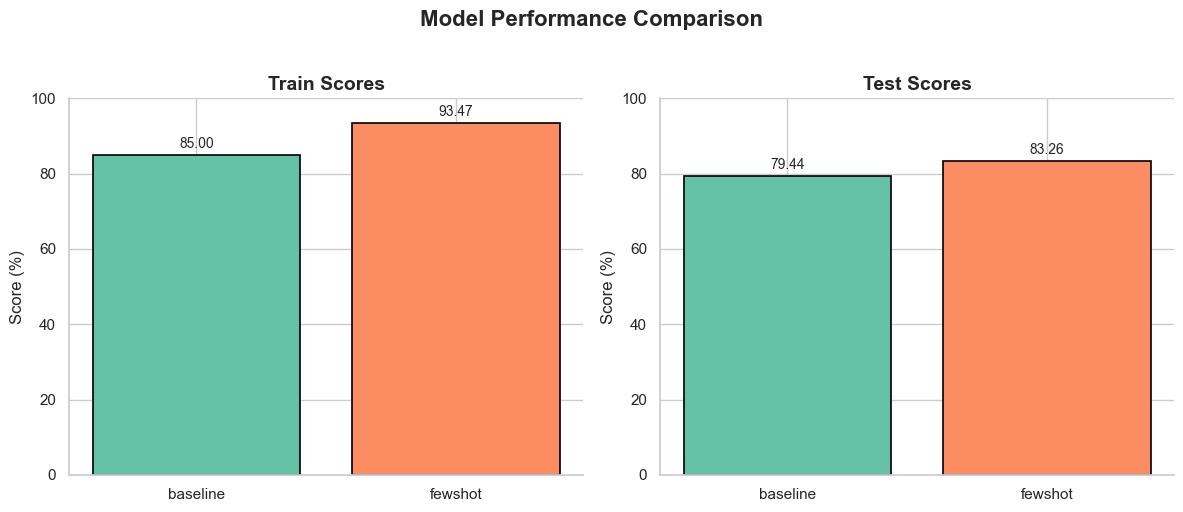

In [ ]:
visualize_model_scores(models_configs)
